Simple Sugihara example, based on this paper http://science.sciencemag.org/content/338/6106/496

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

In [2]:
class Vector:
    '''
    Class of the vector type that maps one-to-many
    t : float
        The abscisa of the vector
    x : numpy array
        The ordinate of the vector
    '''
    
    def __init__(self, t, x):
        self.t = t
        self.x = x
        
class TimeSeries:
    '''
    Class for a time series
    t : numpy array
        The time component 
    x : numpy array
    '''
    def __init__(self, t, x):
        self.t = t
        self.x = x

In [3]:
def shadowManifold (time_series, E, how_long, tau = 1):
    ''' 
    Creates a manifold of lagged Vector objects.
    
    time_series : TimeSeries
                  The TimeSeries object from which the lagged vectors are constructed. 
                  In general it has form {X} = {X(1), X(2), X(3), ..., X(L)}
    E           : int
                  embedding dimension
    how_long    : int
                  length L to be considered for the time series
    tau         : int
                  time step to construct the lagged vectors
    '''
    shadow_M = []

    for i in np.arange(0+(E-1)*tau, len(time_series.t[:how_long]), tau):
        temp_list = []
        for j in np.arange(i-(E-1)*tau, i+1, tau):
            temp_list.append(time_series.x[j])
        shadow_M.append(Vector(t=time_series.t[i], x=np.array(temp_list)))
    
    return shadow_M

def nearestNeighbours (shadow_M, v, n_neigh):
    '''
    Returns the positions (index) of how_many nearest neighbours of v from the shadow
    manifold shadow_M, in order from farthest to closest.
    
    shadow_M : list[Vector]
               shadow manifold consisting of lagged vectors
    v        : Vector
               vector whose closest neighbours we find in shadow_M
    n_neigh  : int
               number of closest neighbors we return
    '''
    dist_list = []
    for i in range(len(shadow_M)):
        dist_list.append(dist.euclidean(shadow_M[i].x, v.x))
    distances = np.array(dist_list) 
    return [np.argsort(distances)[1:n_neigh+1], np.sort(distances)[1:n_neigh+1]] # position 0 is v itself

def weights(distances, x_t, x_t_0):
    if (dist.euclidean(x_t, x_t_0) == 0):
        return np.exp(-distances)/np.sum(np.exp(-distances))
    else:
        return np.exp(-distances/dist.euclidean(x_t, x_t_0))/np.sum(np.exp(-distances/dist.euclidean(x_t, x_t_0)))
        
def generateYApprox (X, Y, E, how_long, tau = 1):
    '''
    Generates the time series Y_tilde (or Y_approximative), cross mapped using time series X, 
    truncated to how_long many elements.
    
    X     :    TimeSeries
               the time series used for cross mapping
    Y     :    TimeSeries
               the time series we cross map
    E     :    int
               embedding dimension
    how_long : int
               how much of the time series we use to generate Y approx
    '''
    Y_tilde_list = []
    time_list = []
    shadow_M = shadowManifold (time_series=X, E=E, how_long=how_long, tau=tau)
    for i in range(len(shadow_M)):
        time_list.append(X.t[i])
        # Build Y tilde
        neigh = nearestNeighbours (shadow_M, shadow_M[i], E+1)
        weigh = weights(neigh[1], shadow_M[i].x, shadow_M[0].x) 
        
        Y_tilde_list.append(np.sum(np.multiply(weigh, Y.x[neigh[0]])))
    return [time_list, Y_tilde_list]

### Paramecium-Didinium protozoan prey-predator system

The data originally comes from this paper Veilleux (1976) "The analysis of a predatory interaction between 
Didinium and Paramecium", Masters thesis, University of Alberta, with the graphics in this paper being scanned and digitized by Jost & Ellner (ref (2000) "Testing for predator dependence in predator-prey dynamics: a non-parametric approach", Proceedings of 
the Royal Society of London B, 267, 1611-1620).

The actual numbers are here https://robjhyndman.com/tsdldata/data/veilleux.dat

The data in Fig. 5A in the Sugihara paper corresponds to the data in Fig. 1A in the Jost & Ellner paper or the Fig. 11a in Veilleux 1976, <b>sans the first 9 data points</b> in order do eliminate transient behaviour in the initial period of the experiment (<b>the Supplementary materials in the Sugihara paper says 10 pts were removed, but the graphic in Fig. 5A corresponds to only 9 pts being removed</b>).

- best embedding dimension E = 3
- leave-one-our cross validation for the Convergent Cross Mapping (CCM)

In [4]:
# Data
time = np.linspace(0, 30.5, 62) # (days)
prey = np.array([86.37, 121, 71.48, 55.78, 31.84, 26.87, 53.24, 65.59, 81.23, 143.9, 237.9, 276.6, 222.2, 137.2, 46.45,
                 27.46, 41.46, 44.73, 88.42, 105.7, 155.2, 205.5, 312.7, 213.7, 163.4, 85.78, 48.64, 44.49, 63.44, 
                 71.66, 127.7, 206.9, 309.9, 156.5, 63.3, 77.29, 45.11, 57.45, 69.8, 121.7, 185.2, 175.3, 139, 77.11, 
                 57.29, 54.79, 75.38, 87.73, 136.4, 290.6, 345.8, 271.6, 156.1, 71.1, 43.86, 30.64, 35.56, 52.03, 
                 37.99, 62.71, 103.9, 187.2]) # (#ind/ml)
predator = np.array([31.11, 58.31, 73.13, 63.21, 52.46, 40.07, 27.67, 26, 24.32, 21, 33.35, 64.67, 94.34, 103.4, 82.74,
                     65.4, 51.35, 28.24, 23.27, 38.09, 14.97, 24.84, 49.56, 75.93, 104, 106.4, 100.6, 84.08, 45.3, 35.37,
                     35.35, 41.1, 52.62, 120.2, 112.8, 92.14, 65.72, 33.54, 21.14, 17.82, 26.04, 65.61, 76.3, 96.07, 68.84,
                     54.79, 35.8, 32.48, 24.21, 35.73, 55.5, 93.41, 117.3, 95.02, 85.92, 82.6, 66.08, 63.58, 37.99, 25.6,
                     23.1, 37.09]) # (#ind/ml)

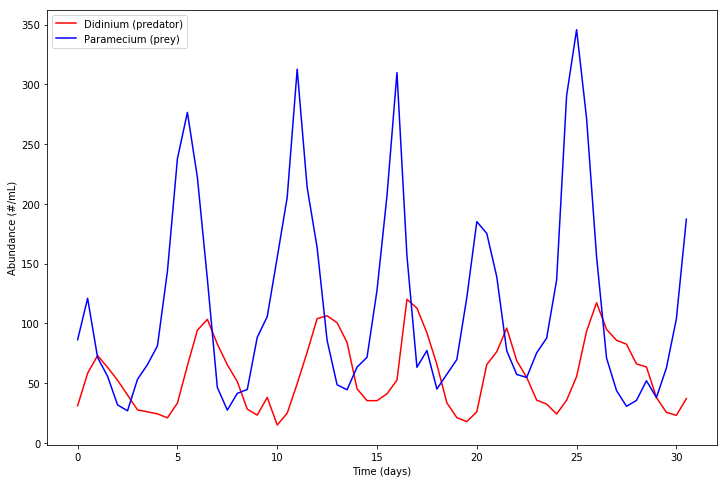

In [5]:
fig = plt.figure(figsize=(12,8))
plt.plot(time, predator, 'r')
plt.plot(time, prey, 'b')
plt.legend(["Didinium (predator)", "Paramecium (prey)"])
plt.xlabel("Time (days)")
plt.ylabel("Abundance (#/mL)")
plt.show()

In [6]:
# Raw data
predator_series = TimeSeries(t=time, x=predator)
prey_series = TimeSeries(t=time, x=prey)
# Embedding dimension
E = 3 # This is used in the paper

# Generate X xmap Y and Y xmap X
corr_pred_xmap_prey = []
corr_prey_xmap_pred = []
L = np.arange(E+7, len(prey_series.x)+1, 1)

for i in L:
    approx_prey_list = generateYApprox(predator_series, prey_series, E=2, how_long=i)
    approx_prey_series = TimeSeries(t=approx_prey_list[0], x=approx_prey_list[1])
    
    approx_pred_list = generateYApprox(prey_series, predator_series, E=2, how_long=i)
    approx_pred_series = TimeSeries(t=approx_pred_list[0], x=approx_pred_list[1])
    
    corr_pred_xmap_prey.append(pearsonr(prey_series.x[:i-1], approx_prey_series.x)[0])
    corr_prey_xmap_pred.append(pearsonr(predator_series.x[:i-1], approx_pred_series.x)[0])

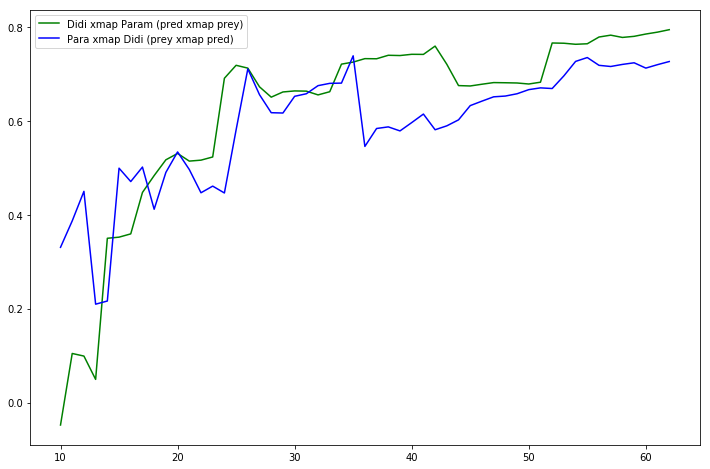

In [7]:
fig = plt.figure(figsize=(12,8))
plt.plot(L, corr_pred_xmap_prey, 'g')
plt.plot(L, corr_prey_xmap_pred, 'b')
plt.legend(["Didi xmap Param (pred xmap prey)", "Para xmap Didi (prey xmap pred)"])
plt.show()

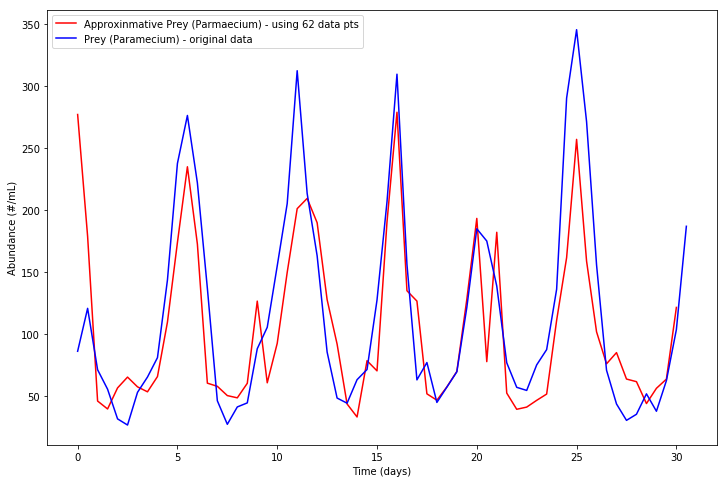

In [8]:
# Example of approximation
L = len(predator_series.t)
approx_prey_list = generateYApprox(predator_series, prey_series, how_long=L, E = 2)
approx_prey_series = TimeSeries(t=approx_prey_list[0], x=approx_prey_list[1])

fig = plt.figure(figsize=(12,8))
plt.plot(approx_prey_series.t, approx_prey_series.x, 'r')
plt.plot(prey_series.t, prey_series.x, 'b')
plt.legend(["Approxinmative Prey (Parmaecium) - using %s data pts" %(L), "Prey (Paramecium) - original data"])
plt.xlabel("Time (days)")
plt.ylabel("Abundance (#/mL)")
plt.show()

### California Current Sardine-Anchovy-SST